In [1]:
from pathlib import Path
import sys, yaml, logging, gc
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# ── repo root so `import src...` works ───────────────────────────
REPO_ROOT = Path.cwd().resolve().parent   # notebook lives in <repo>/notebooks/
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
print("✓ sys.path →", REPO_ROOT)

# project-specific
from src.models.dinogaze_spade_v1 import DinoGazeSpade
from src.models.common.spade_layers import (
    SaliencyNetworkSPADEDynamic, SPADELayerNormDynamic,
)
from src.dinov2_backbone import DinoV2Backbone
from src.modules import build_fixation_selection_network
from src.training import restore_from_checkpoint

from src.data import (
    ImageDatasetWithSegmentation,
    FixationDatasetWithSegmentation,
    FixationMaskTransform,
)
import pysaliency
from pysaliency.baseline_utils import BaselineModel, CrossvalidatedBaselineModel

✓ sys.path → /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation


/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/.pixi/envs/default/lib/python3.11/site-packages/pysaliency/external_models/matlab_models.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# save γ/β maps on every forward – very lightweight

def _forward_with_cache(self, x, painted_semantic_map):
    norm_x = F.layer_norm(x, (self.norm_features, x.size(2), x.size(3)), eps=self.eps)
    sem = F.interpolate(painted_semantic_map, size=x.shape[2:], mode="bilinear", align_corners=False)
    shared = self.mlp_shared(sem)
    gamma = self.mlp_gamma(shared)
    beta  = self.mlp_beta(shared)
    self.last_gamma_map = gamma.detach().cpu()
    self.last_beta_map  = beta.detach().cpu()
    return norm_x * (1 + gamma) + beta

SPADELayerNormDynamic.forward = _forward_with_cache
print("✓ SPADELayerNormDynamic patched → γ/β cached")

✓ SPADELayerNormDynamic patched → γ/β cached


In [3]:
# ----- config (edit) -----
CHECKPOINT = Path("experiments/dinogaze_spade_dynamic_sam64_vitl14_v2/mit_spatial_fold0_dinov2_vitl14_k64_lr5e-05/step-0002.pth")
#CHECKPOINT = Path("/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/experiments/dinogaze_spade_dynamic_sam64_vitl14_v1/mit_scanpath_frozen_fold0_dinov2_vitl14_k64_lr0.0005/step-0054.pth")
DINO_MODEL = "dinov2_vitl14"       # vitb14 / vitl14 / vitg14
PATCH_SIZE = 14
MAIN_LAYERS = [-3, -2, -1]          # as during training
SEMANTIC_LAYER_IDX = -1             # as during training
NUM_SEGMENTS = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ✅ where is your YAML config?
CFG_PATH = Path("/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/configs/scanpath_dinogaze_spade_dynamic_embedding_sam_64.yaml")
# ✅ which checkpoint to load?
CHKPT = Path("experiments/.../step-0002.pth")

In [5]:
cfg = yaml.safe_load(CFG_PATH.read_text())
stage = cfg["stage"]
print("Stage:", stage)

REPO_ROOT = REPO_ROOT  # already defined

def resolve_path(obj):
    if isinstance(obj, str):
        p = Path(obj).expanduser()
        return str(p if p.is_absolute() else (REPO_ROOT / p).resolve())
    if isinstance(obj, list):
        return [resolve_path(x) for x in obj]
    return obj

for k in list(cfg.keys()):
    if any(tok in k for tok in ("dir", "path", "file")):
        cfg[k] = resolve_path(cfg[k])
print("mit_all_mask_dir →", cfg.get("mit_all_mask_dir"))

Stage: mit_scanpath_frozen_dinogaze_dynamic
mit_all_mask_dir → /home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/masks/mit1003/sam_vitl_k64_mit


In [6]:
from torch.utils.data import DataLoader

dataset_dir = Path(cfg["dataset_dir"])

# ---------- build stimuli / fixations / dataset exactly as in training ------
if stage.startswith("salicon"):
    stimuli, fixations = pysaliency.get_SALICON_train(location=str(dataset_dir/"SALICON"))
    centerbias = BaselineModel(stimuli, fixations, bandwidth=0.0217, eps=2e-13, caching=False)
    dataset = ImageDatasetWithSegmentation(
        stimuli, fixations, centerbias,
        segmentation_mask_dir=Path(cfg["salicon_train_mask_dir"]),
        segmentation_mask_format=cfg["segmentation_mask_format"],
        transform=FixationMaskTransform(sparse=False), average="image")

elif stage.startswith("mit_spatial"):
    stimuli, fixations = pysaliency.external_datasets.mit.get_mit1003_with_initial_fixation(
        location=str(dataset_dir), replace_initial_invalid_fixations=True)
    centerbias = CrossvalidatedBaselineModel(
        stimuli, fixations, bandwidth=10**-1.6668, eps=10**-14.884, caching=False)
    dataset = ImageDatasetWithSegmentation(
        stimuli, fixations, centerbias,
        segmentation_mask_dir=Path(cfg["mit_all_mask_dir"]),
        segmentation_mask_format=cfg["segmentation_mask_format"],
        transform=FixationMaskTransform(sparse=False), average="image")

elif "mit_scanpath" in stage:
    stimuli, fixations = pysaliency.external_datasets.mit.get_mit1003_with_initial_fixation(
        location=str(dataset_dir), replace_initial_invalid_fixations=True)
    centerbias = CrossvalidatedBaselineModel(
        stimuli, fixations, bandwidth=10**-1.6668, eps=10**-14.884, caching=False)
    dataset = FixationDatasetWithSegmentation(
        stimuli, fixations, centerbias,
        included_fixations=[-1,-2,-3,-4], allow_missing_fixations=True,
        segmentation_mask_dir=Path(cfg["mit_all_mask_dir"]),
        segmentation_mask_format=cfg["segmentation_mask_format"],
        transform=FixationMaskTransform(sparse=False), average="image")
else:
    raise ValueError("Unsupported stage:", stage)

print(f"✓ dataset built — {len(dataset)} samples")
sample = next(iter(DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)))
print("✓ dataset OK →", sample["image"].shape)

✓ dataset built — 119216 samples
✓ dataset OK → torch.Size([1, 3, 683, 1024])


In [7]:
import torch.nn as nn

DINO_MODEL = cfg.get("dino_model_name", "dinov2_vitl14")
PATCH_SIZE = cfg.get("dino_patch_size", 14)
LAYERS = cfg.get("dino_layers_for_main_path", [-3, -2, -1])
SEM_IDX = cfg.get("dino_semantic_feature_layer_idx", -1)
NUM_SEG = cfg.get("num_total_segments", 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = DinoV2Backbone(layers=cfg["dino_layers_for_main_path"],
                          model_name=cfg["dino_model_name"],
                          patch_size=cfg["dino_patch_size"],
                          freeze=True)
C_main = len(cfg["dino_layers_for_main_path"]) * backbone.num_channels
C_sem  = backbone.num_channels

model = DinoGazeSpade(
    features_module=backbone,
    saliency_network=SaliencyNetworkSPADEDynamic(C_main, C_sem),
    fixation_selection_network=build_fixation_selection_network(scanpath_features=0),
    scanpath_network=None,
    semantic_feature_layer_idx=cfg["dino_semantic_feature_layer_idx"],
    num_total_segments=cfg["num_total_sam_segments"])

restore_from_checkpoint(model, None, None, None,
                        path=str(CHKPT), device="cpu",
                        is_distributed=False, logger=logging.getLogger("restore"))
print("✓ checkpoint loaded")

# replace fixation-selection with identity to ignore scanpath branch
class PassSal(nn.Module):
    def forward(self, x_pair, *_, **__):
        return x_pair[0] if isinstance(x_pair, (list, tuple)) else x_pair
model.fixation_selection_network = PassSal()

#13471
#81221
#14389

Using cache found in /home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main
/home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/mmorello/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Checkpoint path 'experiments/.../step-0002.pth' not found or not specified. Cannot restore.


✓ checkpoint loaded


/tmp/ipykernel_489147/999555966.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), amp.autocast(dtype=torch.float16):


sample 71344 | image 768×1024 | saliency grid 192×256 | 1 GT fixations plotted
x_hist: [nan nan nan nan] y_hist: [nan nan nan nan]
#mask-pixels > 1


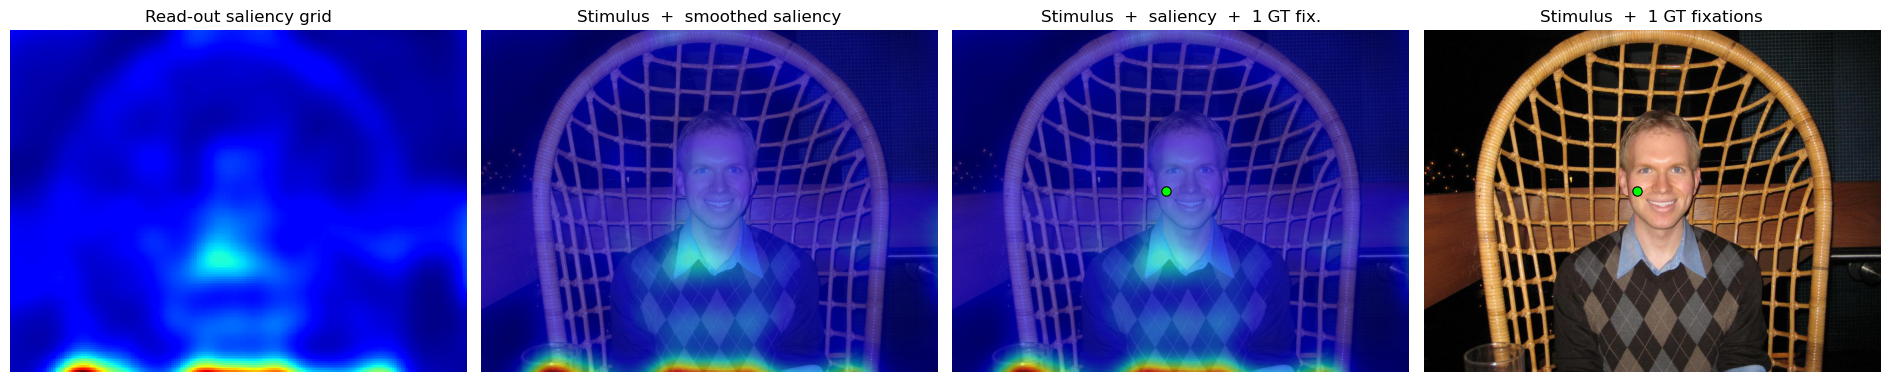

In [50]:
# %% ------------------------------------------------------------
# one-cell “sanity run”   ·   saliency + ALL GT fixations
# ---------------------------------------------------------------
import gc, math, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn, torch.nn.functional as F
import torch.cuda.amp as amp

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. pick *one* random sample ------------------------------------------
ds_idx = torch.randint(len(dataset), ()).item()
raw    = dataset[ds_idx]                           # dict with numpy / tensors
H0, W0 = raw["image"].shape[-2:]                  # stimulus resolution

to_dev = lambda x,dtype: torch.as_tensor(x, dtype=dtype, device=DEVICE)
img   = to_dev(raw["image"]           , torch.float16).unsqueeze(0)   # 1×3×H×W
mask  = to_dev(raw["segmentation_mask"], torch.long ).unsqueeze(0)    # 1×H×W
cbias = torch.zeros((1, H0, W0), dtype=torch.float16, device=DEVICE)  # full-res CB

# ─── 2. make fixation-selection a pass-through -----------------------------
class _Pass(nn.Module):
    def forward(self, x, *_, **__):
        return x[0] if isinstance(x, (list, tuple)) else x
model.fixation_selection_network = _Pass()

# ─── 3. forward pass -------------------------------------------------------
gc.collect(); torch.cuda.empty_cache()
model = model.half().to(DEVICE).eval()

with torch.inference_mode(), amp.autocast(dtype=torch.float16):
    log_dens = model(img, centerbias=cbias, segmentation_mask=mask)   # 1×1×H×W
prob_full = log_dens.exp().squeeze().float().cpu()      # (H,W) – smoothed map

# also grab the raw read-out grid (for curiosity)
sf         = getattr(model.finalizer, "saliency_map_factor", 4)
Hr, Wr     = math.ceil(H0/sf), math.ceil(W0/sf)
prob_grid  = F.interpolate(prob_full[None,None], (Hr,Wr), mode="area")[0,0]

# ─── 4. collect *all* GT fixation coordinates -----------------------------
# (a) last fixation – from the binary mask
fm = raw["fixation_mask"]
fm = fm.cpu().numpy() if torch.is_tensor(fm) else fm
ys_last, xs_last = np.nonzero(fm > 0)

# (b) previous 3 fixations – from x_hist / y_hist
x_hist = np.asarray(raw["x_hist"])
y_hist = np.asarray(raw["y_hist"])
valid  = (x_hist >= 0) & (x_hist < W0) & (y_hist >= 0) & (y_hist < H0)
xs_hist = x_hist[valid]
ys_hist = y_hist[valid]

# concatenate
xs = np.concatenate([xs_hist, xs_last])
ys = np.concatenate([ys_hist, ys_last])

print(f"sample {ds_idx:4d} | image {H0}×{W0} | saliency grid {Hr}×{Wr} | "
      f"{len(xs)} GT fixations plotted")
print("x_hist:", x_hist, "y_hist:", y_hist)
print("#mask-pixels >", (fm > 0).sum())


# ─── 5. stimulus image as H,W,C float for mpl ------------------------------
stim = raw["image"].astype(np.float32)
if stim.shape[0] <= 4: stim = np.transpose(stim, (1,2,0))
stim /= (255. if stim.max() > 1 else 1)

# ─── 6. figure -------------------------------------------------------------
fig, ax = plt.subplots(1, 4, figsize=(19, 6))

ax[0].imshow(prob_grid, cmap="jet", interpolation="nearest")
ax[0].set_title("Read-out saliency grid");  ax[0].axis("off")

ax[1].imshow(stim);  ax[1].imshow(prob_full, cmap="jet", alpha=.6)
ax[1].set_title("Stimulus  +  smoothed saliency");  ax[1].axis("off")

ax[2].imshow(stim);  ax[2].imshow(prob_full, cmap="jet", alpha=.6)
ax[2].scatter(xs, ys, s=45, c="lime", edgecolors="black", linewidths=.8)
ax[2].set_title(f"Stimulus  +  saliency  +  {len(xs)} GT fix.");  ax[2].axis("off")

# plot the original image with GT fixations
ax[3].imshow(stim);  ax[3].scatter(xs, ys, s=45, c="lime", edgecolors="black", linewidths=.8)
ax[3].set_title(f"Stimulus  +  {len(xs)} GT fixations");  ax[3].axis("off")

plt.tight_layout(); plt.show()


Using cache found in /home/mmorello/.cache/torch/hub/pytorch_vision_v0.6.0
/tmp/ipykernel_489147/1592885659.py:95: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  _np.dtype, _np.dtypes.Float64DType, _np.dtypes.Float32DType, _np.core.multiarray.scalar


→ loaded head weights   |   missing: 21   unexpected: 21


/tmp/ipykernel_489147/1592885659.py:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), amp.autocast(dtype=torch.float16):   # <- no "cuda"


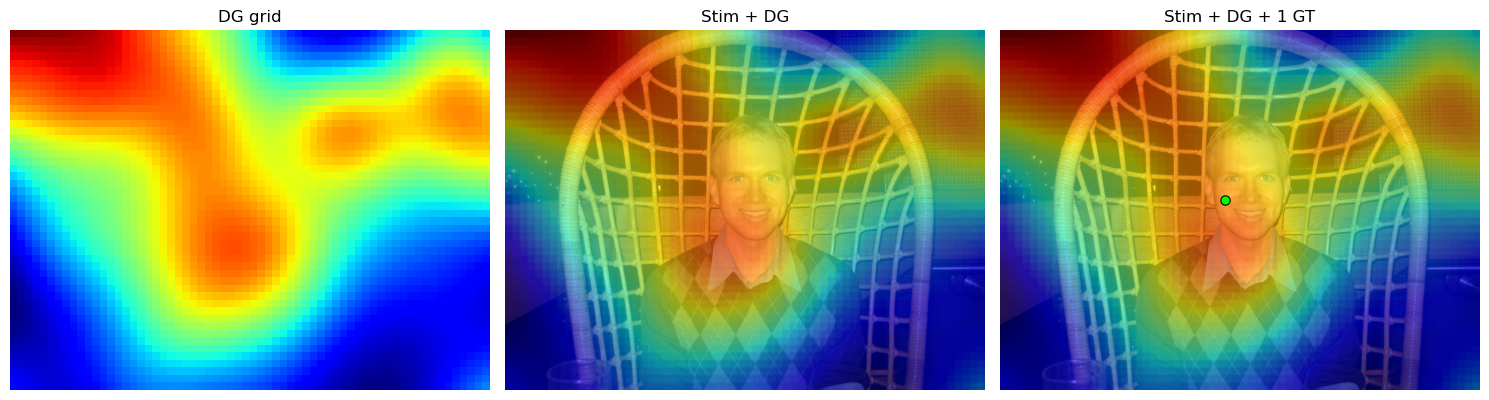

In [51]:
# %%  DeepGaze-III  ·  saliency-only quick-viz  (drop the None argument cleanly)
# ---------------------------------------------------------------------------
import torch, numpy as np, random, gc, math, matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace, MethodType
import torch.nn.functional as F
import torch.cuda.amp as amp
import types

# ---- deterministic, optional ----------------------------------------------
torch.manual_seed(0); np.random.seed(0); random.seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# 1. build the exact architecture used for training (DenseNet-201 backbone)
# ---------------------------------------------------------------------------
from DeepGaze.deepgaze_pytorch.features.densenet import RGBDenseNet201
from src.modules import DeepGazeIII, FeatureExtractor
from src.layers   import Bias, LayerNorm, Conv2dMultiInput, LayerNormMultiInput
from collections  import OrderedDict

# DenseNet-201 with the three hooks the training script used
base_net = RGBDenseNet201()
hook_nodes = [
    '1.features.denseblock4.denselayer32.norm1',   # 1888 C
    '1.features.denseblock4.denselayer32.conv1',   # 128 C
    '1.features.denseblock4.denselayer31.conv2',   # 32 C
]
features = FeatureExtractor(base_net, hook_nodes)
for p in features.parameters(): p.requires_grad = False
features.eval()

# saliency-head identical to training script (expects 2048 C)
def build_saliency_network(C_in: int):
    import torch.nn as nn
    return nn.Sequential(OrderedDict([
        ('ln0',  LayerNorm(C_in)),
        ('c0',   nn.Conv2d(C_in, 8, 1, bias=False)), ('b0', Bias(8)), ('sp0', nn.Softplus()),
        ('ln1',  LayerNorm(8)),    ('c1',   nn.Conv2d(8,16,1,bias=False)), ('b1', Bias(16)), ('sp1', nn.Softplus()),
        ('ln2',  LayerNorm(16)),   ('c2',   nn.Conv2d(16,1,1,bias=False)), ('b2', Bias(1)),  ('sp2', nn.Softplus()),
    ]))

saliency_net = build_saliency_network(2048)

# fixation-selection kept, scanpath None (SALICON stage)
from src.layers import FlexibleScanpathHistoryEncoding  # if needed later
def build_fixsel():
    in_ch = [1]   # only saliency map
    return torch.nn.Sequential(OrderedDict([
        ('ln0', LayerNormMultiInput(in_ch)),
        ('c0',  Conv2dMultiInput(in_ch, 128, 1, bias=False)), ('b0', Bias(128)), ('sp0', torch.nn.Softplus()),
        ('ln1', LayerNorm(128)), ('c1', torch.nn.Conv2d(128,16,1,bias=False)), ('b1', Bias(16)), ('sp1', torch.nn.Softplus()),
        ('c2',  torch.nn.Conv2d(16,1,1,bias=False)),
    ]))

dg_model = DeepGazeIII(
    features=features,
    saliency_network=saliency_net,
    scanpath_network=None,
    fixation_selection_network=build_fixsel(),
    downsample=1.5,
    readout_factor=4,
    saliency_map_factor=4,
    included_fixations=[]
).half().to(DEVICE)      # ← keep the module

dg_model.eval()          # in-place; DON’T re-assign


def _forward_saliency_only(self, x, centerbias, *hist, **kw):
    # ------------------------------------------------------------------ #
    # 1) DenseNet feature stack → 2048-C tensor                          #
    # ------------------------------------------------------------------ #
    feats = self.features(x)
    feat  = torch.cat(feats, dim=1) if isinstance(feats, (list, tuple)) else feats

    # ------------------------------------------------------------------ #
    # 2) saliency → fixation-selection → finalizer                       #
    # ------------------------------------------------------------------ #
    sal = self.saliency_network(feat)           # (B,1,H,W)

    z   = self.fixation_selection_network((sal,))   # <-- no “None”
    z   = self.finalizer(z, centerbias)              # log-space CB
    return z

# attach it
dg_model.forward = MethodType(_forward_saliency_only, dg_model)

# ---------------------------------------------------------------------------
# 2. load checkpoint – this time it should be 100 % match
# ---------------------------------------------------------------------------
import torch.serialization, numpy as _np
torch.serialization.add_safe_globals([
    _np.dtype, _np.dtypes.Float64DType, _np.dtypes.Float32DType, _np.core.multiarray.scalar
])

CKPT = Path(
    "/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/"
    "experiments/experiments_deepgaze_original/"
    "salicon_pretraining_original_densenet/step-0031.pth"
)
# 1 ─── load the checkpoint bundle
bundle = torch.load(CKPT, map_location="cpu")

# 2 ─── extract the part that actually corresponds to nn.Module weights
state_dict = bundle["model"] if "model" in bundle else bundle

# 3 ─── load ONLY those weights; keep ImageNet backbone as-is
missing, unexpected = dg_model.load_state_dict(state_dict, strict=False)
print(f"→ loaded head weights   |   missing: {len(missing)}   unexpected: {len(unexpected)}")
# ---------------------------------------------------------------------------
# 3. quick saliency-only forward (centre-bias at *grid* resolution)
# ---------------------------------------------------------------------------
# one random sample, as you had
ds_idx = torch.randint(len(dataset), ()).item()
raw    = dataset[ds_idx]
H0, W0 = raw["image"].shape[-2:]
img    = torch.as_tensor(raw["image"], dtype=torch.float16, device=DEVICE)[None]

# read-out size
sf  = dg_model.finalizer.saliency_map_factor
Hr, Wr = math.ceil(H0/sf), math.ceil(W0/sf)

log_cbias_grid = torch.zeros((1, Hr, Wr), dtype=torch.float16, device=DEVICE)


with torch.inference_mode(), amp.autocast(dtype=torch.float16):   # <- no "cuda"
    log_grid = dg_model(img, log_cbias_grid)

prob_grid = log_grid.exp().squeeze().float().cpu()
prob_full = F.interpolate(prob_grid[None,None],[H0,W0], mode="bilinear", align_corners=False)[0,0]

# ── 6. figure ──────────────────────────────────────────────────────────────
# H0, W0 are the stimulus’ height and width
extent = [0, W0, H0, 0]          # [xmin, xmax, ymin, ymax]  (y inverted)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1) raw saliency grid (upsampled or not)
ax[0].imshow(prob_grid, cmap="jet",
             interpolation="nearest",
             extent=extent)
ax[0].set_title("DG grid")

# 2) stimulus + saliency overlay
ax[1].imshow(stim,                extent=extent)
ax[1].imshow(prob_full, alpha=.6, extent=extent, cmap="jet")
ax[1].set_title("Stim + DG")

# 3) overlay with GT fixations
ax[2].imshow(stim,                extent=extent)
ax[2].imshow(prob_full, alpha=.6, extent=extent, cmap="jet")
ax[2].scatter(xs, ys, s=45, c="lime", edgecolors="k", lw=.8)
ax[2].set_title(f"Stim + DG + {len(xs)} GT")

# --- same for every panel -----------------------------------------------
for a in ax:
    a.set_aspect("equal")         # 1 px in x == 1 px in y
    a.set_xlim(0, W0)             # keep exact bounds
    a.set_ylim(H0, 0)             # (0,0) top-left
    a.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# helpers_dg_orig.py -------------------------------------------------
from collections import OrderedDict
import torch.nn as nn
from src.layers import Bias, LayerNorm, LayerNormMultiInput, Conv2dMultiInput

def build_saliency_network(C_in: int = 2048):
    return nn.Sequential(OrderedDict([
        ('ln0',  LayerNorm(C_in)),
        ('c0',   nn.Conv2d(C_in, 8, 1, bias=False)),  ('b0', Bias(8)),  ('sp0', nn.Softplus()),
        ('ln1',  LayerNorm(8)),
        ('c1',   nn.Conv2d(8,16,1, bias=False)),      ('b1', Bias(16)), ('sp1', nn.Softplus()),
        ('ln2',  LayerNorm(16)),
        ('c2',   nn.Conv2d(16,1,1, bias=False)),      ('b2', Bias(1)),  ('sp2', nn.Softplus()),
    ]))

def build_fixsel(scanpath_features: int = 0):
    in_ch = [1, scanpath_features]          # second branch is 0 for SALICON
    return nn.Sequential(OrderedDict([
        ('ln0', LayerNormMultiInput(in_ch)),
        ('c0',  Conv2dMultiInput(in_ch, 128, 1, bias=False)), ('b0', Bias(128)), ('sp0', nn.Softplus()),
        ('ln1', LayerNorm(128)), ('c1', nn.Conv2d(128,16,1, bias=False)), ('b1', Bias(16)), ('sp1', nn.Softplus()),
        ('c2',  nn.Conv2d(16,1,1, bias=False)),
    ]))


import torch, math
from DeepGaze.deepgaze_pytorch.features.densenet import RGBDenseNet201
from src.modules import DeepGazeIII, FeatureExtractor

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# backbone & hooks
backbone = RGBDenseNet201()
hook_nodes = [
    '1.features.denseblock4.denselayer32.norm1',   # 1888 C
    '1.features.denseblock4.denselayer32.conv1',   # 128 C
    '1.features.denseblock4.denselayer31.conv2',   #  32 C
]
features = FeatureExtractor(backbone, hook_nodes).eval()
for p in features.parameters(): p.requires_grad = False

# heads
sal_net  = build_saliency_network(2048)
fix_net  = build_fixsel(scanpath_features=0)       # no scan‑path branch

model = DeepGazeIII(
    features               = features,
    saliency_network       = sal_net,
    scanpath_network       = None,                 # SALICON stage
    fixation_selection_network = fix_net,
    downsample             = 1.5,
    readout_factor         = 4,
    saliency_map_factor    = 4,
    included_fixations     = [],
).to(DEVICE).half()
model.eval()


ckpt_path = (
    "/home/mmorello/Decoding_Neural_Dynamics_of_Visual_Perceptual_Segmentation/experiments/train_deepgaze3/MIT1003_spatial/crossval-10-0/final.pth"
)
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
state = ckpt['model'] if 'model' in ckpt else ckpt          # either style
missing, unexpected = model.load_state_dict(state, strict=False)
print('missing:', len(missing), '  unexpected:', len(unexpected))


import numpy as np, torch.nn.functional as F
from torchvision.transforms.functional import normalize

def preprocess_uint8(img_np):
    """
    img_np : uint8 numpy array coming from the dataloader, already (C,H,W)
    returns : float tensor (1,3,H,W) ImageNet‑normalised
    """
    img = torch.as_tensor(img_np).float().div_(255.)        # (3,H,W)

    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225], device=img.device)[:, None, None]

    img = normalize(img, mean, std)                         # now OK
    return img.unsqueeze(0)      

# ---- one picture --------------------------------------------------
raw = dataset[123]
img = preprocess_uint8(raw['image']).to(DEVICE).half()

H0, W0 = img.shape[-2:]
Hr, Wr = math.ceil(H0/4), math.ceil(W0/4)      # read‑out grid
cbias_grid = torch.zeros((1,Hr,Wr), dtype=torch.float16, device=DEVICE)

with torch.no_grad(), torch.autocast('cuda', dtype=torch.float16):
    log_grid = model(img, cbias_grid)          # 1×1×Hr×Wr

prob_grid = log_grid.exp().squeeze().float().cpu()        # Hr×Wr
prob_full = F.interpolate(prob_grid[None,None],[H0,W0], mode='bilinear',
                           align_corners=False)[0,0]      # H0×W0



Using cache found in /home/mmorello/.cache/torch/hub/pytorch_vision_v0.6.0


missing: 21   unexpected: 21


RuntimeError: The size of tensor a (1024) must match the size of tensor b (3) at non-singleton dimension 0

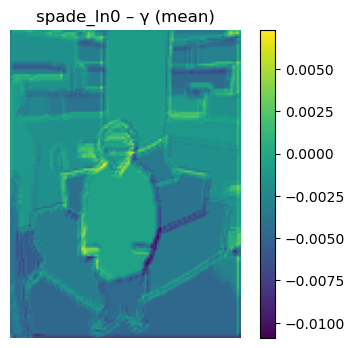

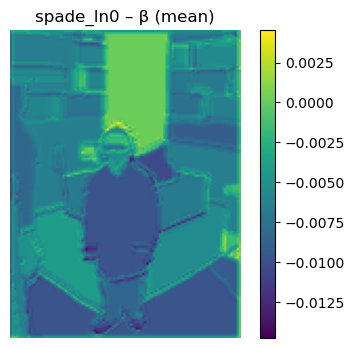

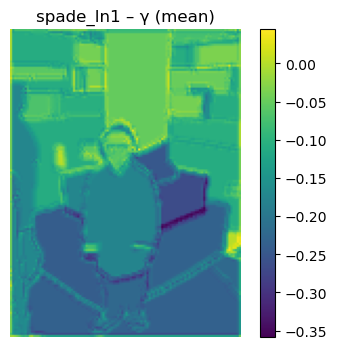

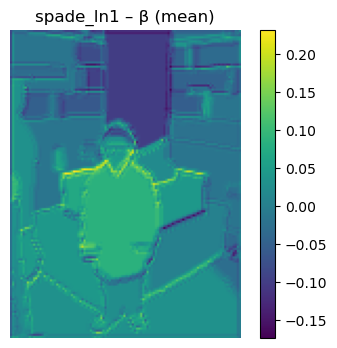

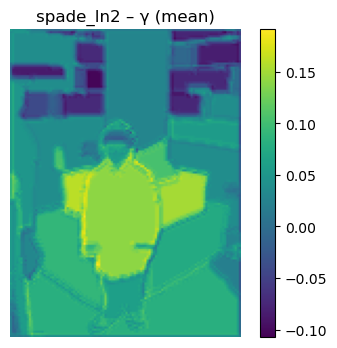

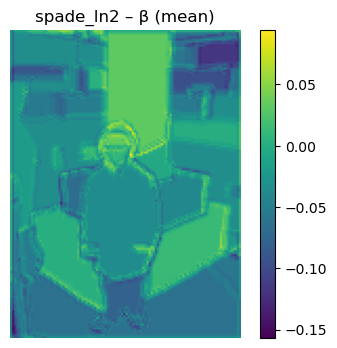

In [45]:
def show_map(arr, title, cmap="viridis"):
    plt.figure(figsize=(5,4))
    plt.title(title); plt.imshow(arr, cmap=cmap)
    plt.axis("off"); plt.colorbar(); plt.show()

for lname in ["spade_ln0", "spade_ln1", "spade_ln2"]:
    layer = getattr(model.saliency_network, lname)
    g = layer.last_gamma_map.mean(1)[0].cpu().numpy()   # mean across channels
    b = layer.last_beta_map .mean(1)[0].cpu().numpy()
    show_map(g, f"{lname} – γ (mean)")
    show_map(b, f"{lname} – β (mean)")
